In [1]:
# prompt: mount colab

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install required packages**

In [3]:
!pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00


In [4]:
import anvil.server

anvil.server.connect("ANVIL-CONNECT-API-KEY")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [5]:
@anvil.server.callable
def check_phishing(link):
    # Your phishing detection code here
    result = "Phishing" if is_phishing(link) else "Safe"
    return result

In [6]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


In [7]:
%pip install dask

In [8]:
pip install flask-ngrok

**Change Directories to the folder of the model**

In [9]:
cd /content/drive/MyDrive/PhishingPrediction

/content/drive/MyDrive/PhishingPrediction


**Using a combined classified of RF+XGB to predict if a link is phishing or not**

In [10]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template
import pickle
import numpy as np

In [11]:
import re
import pandas as pd
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/PhishingPrediction/dataset_phishing.csv')
df.dropna(inplace=True)

# Feature Selection
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

X = df[features]
y = df['status']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize S
combined_rf_xgb = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
], voting='soft')

# Train the Combined Classifier (RF + XGB)
combined_rf_xgb.fit(X_train_scaled, y_train)

# Save the trained model as a .pkl file
model_path = '/content/drive/MyDrive/PhishingPrediction/model.pkl'
joblib.dump(combined_rf_xgb, model_path)

print(f"Model saved to {model_path}")

# Function to extract features from a URL
def extract_features_from_url(url):
    # Parse the URL
    parsed_url = urlparse(url)

    # Extract features
    features = {
        'length_url': len(url),
        'length_hostname': len(parsed_url.netloc),
        'ip': 1 if re.match(r'\d+\.\d+\.\d+\.\d+', parsed_url.netloc) else 0,
        'nb_dots': url.count('.'),
        'nb_hyphens': url.count('-'),
        'nb_at': url.count('@'),
        'nb_qm': url.count('?'),
        'nb_and': url.count('&'),
        'nb_or': url.count('|'),
        'nb_eq': url.count('='),
        'nb_underscore': url.count('_'),
        'nb_tilde': url.count('~'),
        'nb_percent': url.count('%'),
        'nb_slash': url.count('/'),
        'nb_star': url.count('*'),
        'nb_colon': url.count(':'),
        'nb_comma': url.count(','),
        'nb_semicolumn': url.count(';'),
        'nb_dollar': url.count('$'),
        'nb_space': url.count(' '),
        'nb_www': url.count('www'),
        'nb_com': url.count('.com'),
        'nb_dslash': url.count('//'),
        'http_in_path': 1 if 'http' in parsed_url.path else 0,
        'https_token': 1 if 'https' in parsed_url.netloc else 0,
        'ratio_digits_url': sum(c.isdigit() for c in url) / len(url),
        'ratio_digits_host': sum(c.isdigit() for c in parsed_url.netloc) / len(parsed_url.netloc),
        'punycode': 1 if 'xn--' in url else 0,
        'shortening_service': 1 if re.match(r'(bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly)', parsed_url.netloc) else 0,
        'path_extension': 1 if re.search(r'\.\w{2,4}$', parsed_url.path) else 0,
        'phish_hints': 1 if re.search(r'(login|signin|bank|update|account|secure|webscr|confirm|password|verify|activity|ebayisapi|paypal|session|cmd|admin|customer|authentication|identity|webapps|webscr)', url) else 0,
        'domain_in_brand': 1 if re.search(r'(paypal|ebay|amazon|bank|secure|account|login|signin|update|verify|password|confirm|activity|session|cmd|admin|customer|authentication|identity|webapps|webscr)', parsed_url.netloc) else 0,
        'brand_in_subdomain': 1 if re.search(r'(paypal|ebay|amazon|bank|secure|account|login|signin|update|verify|password|confirm|activity|session|cmd|admin|customer|authentication|identity|webapps|webscr)', parsed_url.hostname.split('.')[0]) else 0,
        'brand_in_path': 1 if re.search(r'(paypal|ebay|amazon|bank|secure|account|login|signin|update|verify|password|confirm|activity|session|cmd|admin|customer|authentication|identity|webapps|webscr)', parsed_url.path) else 0,
        'suspecious_tld': 1 if parsed_url.netloc.split('.')[-1] in ['zip', 'review', 'country', 'kim', 'cricket', 'science', 'work', 'party', 'gq', 'link', 'men', 'stream', 'download', 'xin', 'racing', 'jetzt', 'win', 'accountants', 'date', 'faith', 'loan', 'trade', 'webcam', 'xyz', 'top', 'club', 'wang', 'space', 'bid', 'party'] else 0
    }
    return pd.DataFrame([features])




Model saved to /content/drive/MyDrive/PhishingPrediction/model.pkl


**Anvil Callable function that takes an URL and outputs 'Legitimate' or 'Phishing'**

In [18]:
# Function to predict if a URL is phishing or not
@anvil.server.callable
def predict_phishing(url):
    # Extract features from the URL
    url_features = extract_features_from_url(url)

    # Scale the features
    url_features_scaled = scaler.transform(url_features)

    # Predict using the trained model
    prediction = combined_rf_xgb.predict(url_features_scaled)

    # Return the prediction result
    return "Phishing" if prediction[0] == 1 else "Legitimate"

# Example usage
url = "https://amazoon.com"
result = predict_phishing(url)
print(f"The URL '{url}' is predicted to be: {result}")

The URL 'https://amazoon.com' is predicted to be: Phishing


**Comparison of all the other methods**

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


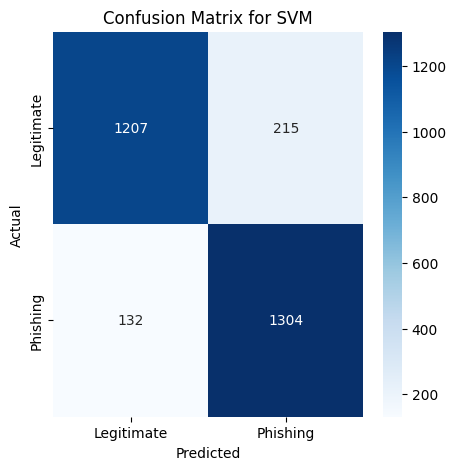

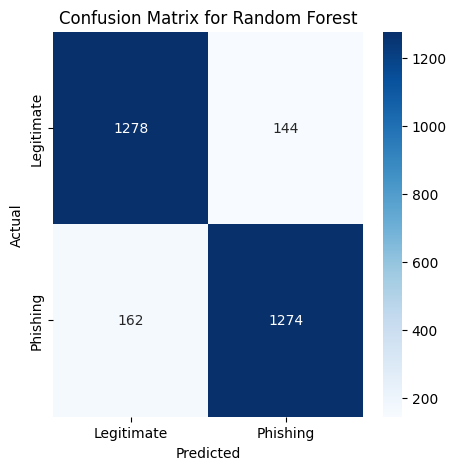

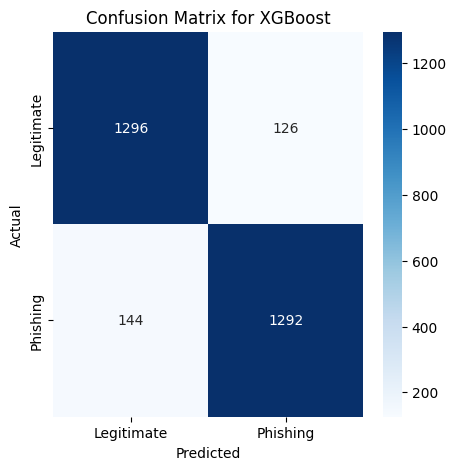

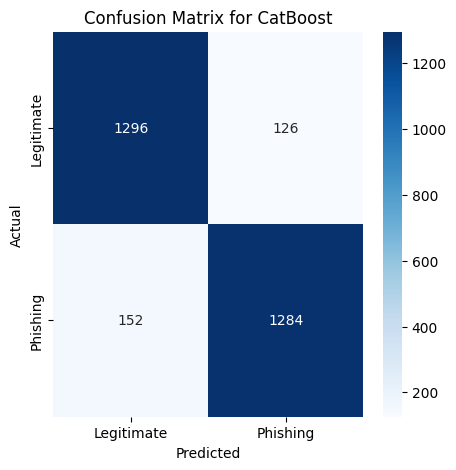

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


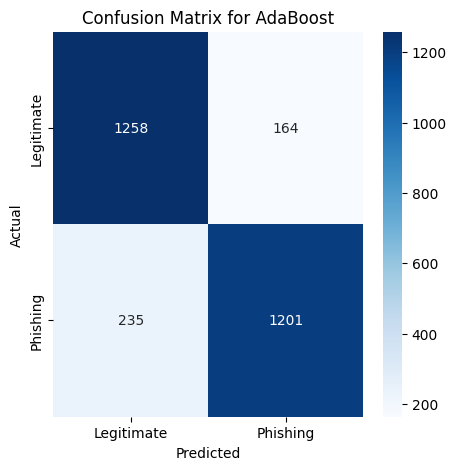

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

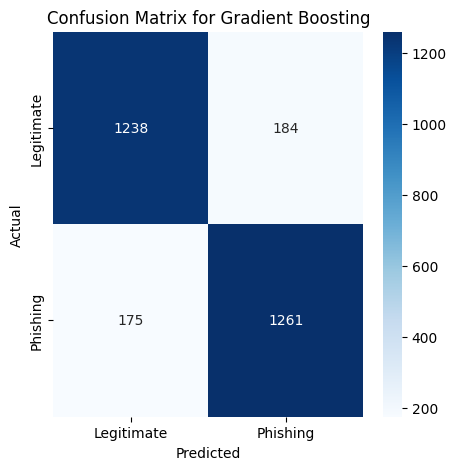

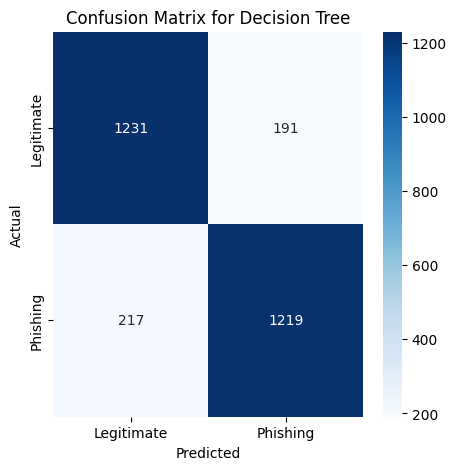

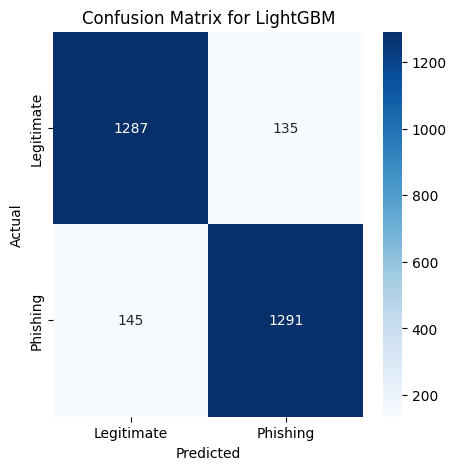

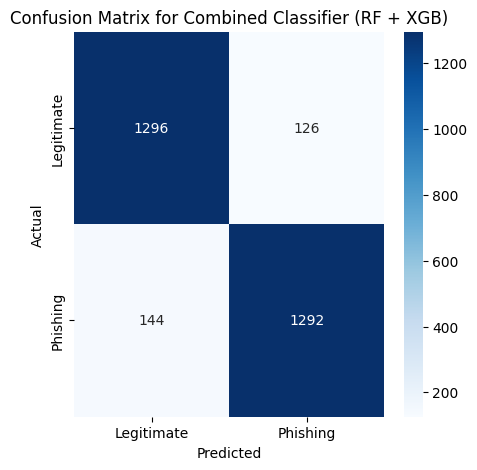

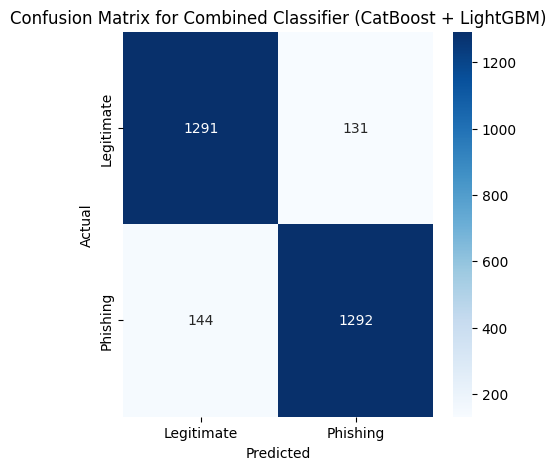

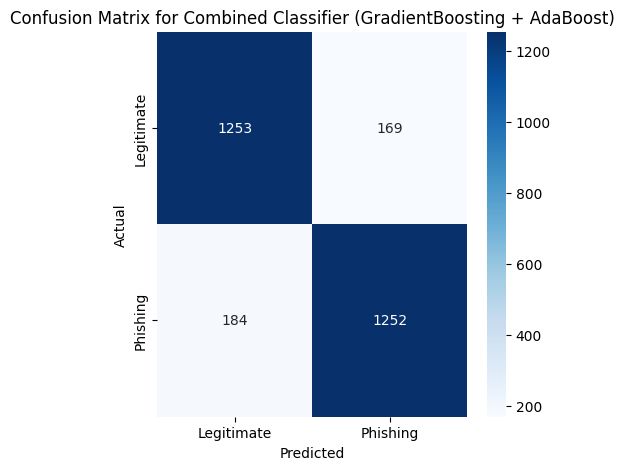

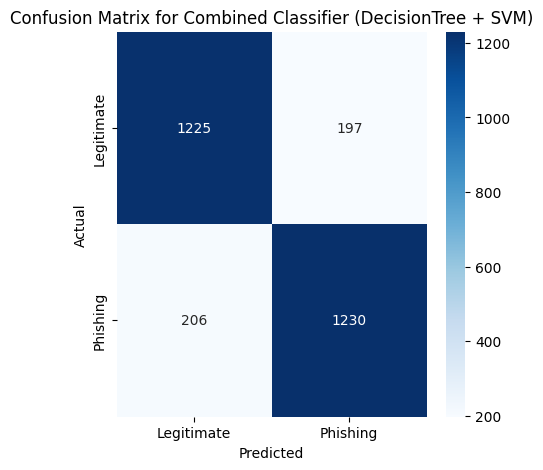

Model: SVM
Cross-Validated Accuracy: 0.8534
Cross-Validated Precision: 0.8279
Cross-Validated Recall: 0.8920
Cross-Validated F1-Score: 0.8586
------------------------------------------------------------
Model: Random Forest
Cross-Validated Accuracy: 0.8905
Cross-Validated Precision: 0.8878
Cross-Validated Recall: 0.8904
Cross-Validated F1-Score: 0.8881
------------------------------------------------------------
Model: XGBoost
Cross-Validated Accuracy: 0.8928
Cross-Validated Precision: 0.8882
Cross-Validated Recall: 0.8983
Cross-Validated F1-Score: 0.8932
------------------------------------------------------------
Model: CatBoost
Cross-Validated Accuracy: 0.8950
Cross-Validated Precision: 0.8927
Cross-Validated Recall: 0.8976
Cross-Validated F1-Score: 0.8951
------------------------------------------------------------
Model: AdaBoost
Cross-Validated Accuracy: 0.8466
Cross-Validated Precision: 0.8589
Cross-Validated Recall: 0.8292
Cross-Validated F1-Score: 0.8437
----------------------

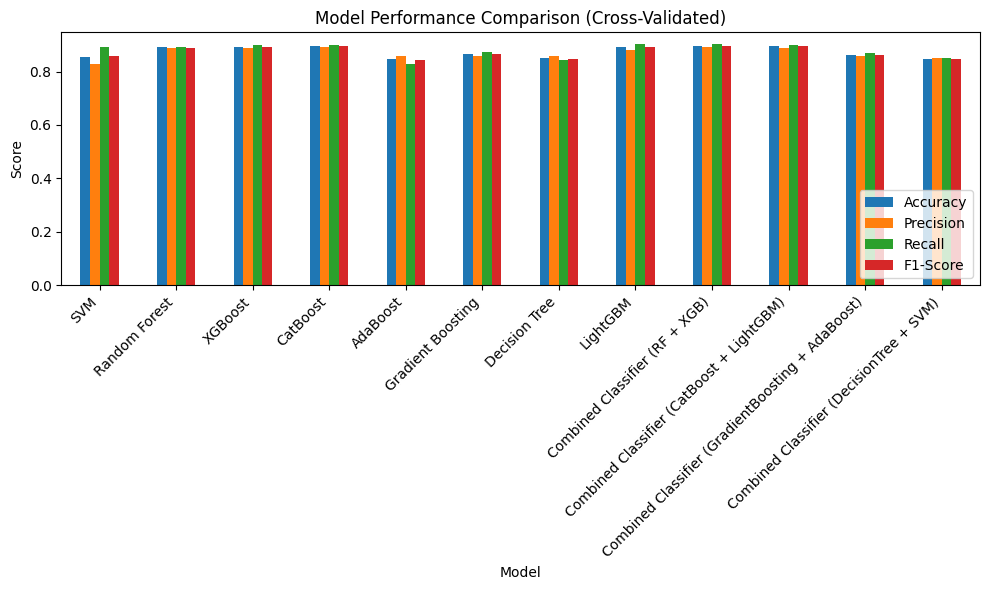

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/PhishingPrediction/dataset_phishing.csv')
df.dropna(inplace=True)

# Feature Selection
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

X = df[features]
y = df['status']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Classifiers
combined_rf_xgb = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
], voting='soft')

combined_catboost_lgbm = VotingClassifier(estimators=[
    ('catboost', CatBoostClassifier(verbose=0)),
    ('lgbm', LGBMClassifier(verbose=0))
], voting='soft')

combined_gb_adaboost = VotingClassifier(estimators=[
    ('gb', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier(algorithm = 'SAMME'))
], voting='soft')

combined_dt_svm = VotingClassifier(estimators=[
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(probability=True))
], voting='soft')

classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1),
    'Combined Classifier (RF + XGB)': combined_rf_xgb,
    'Combined Classifier (CatBoost + LightGBM)': combined_catboost_lgbm,
    'Combined Classifier (GradientBoosting + AdaBoost)': combined_gb_adaboost,
    'Combined Classifier (DecisionTree + SVM)': combined_dt_svm
}

# Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# Cross-Validation Training, Evaluation and Confusion Matrix Calculation
for name, clf in classifiers.items():
    # Fit the classifier
    clf.fit(X_train_scaled, y_train)

    # Predict the test set
    y_pred = clf.predict(X_test_scaled)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Cross-validation on the training set
    cv_accuracy = cross_val_score(clf, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    cv_precision = cross_val_score(clf, X_train_scaled, y_train, cv=skf, scoring='precision')
    cv_recall = cross_val_score(clf, X_train_scaled, y_train, cv=skf, scoring='recall')
    cv_f1 = cross_val_score(clf, X_train_scaled, y_train, cv=skf, scoring='f1')

    # Storing cross-validated results
    results[name] = {
        'Accuracy': np.mean(cv_accuracy),
        'Precision': np.mean(cv_precision),
        'Recall': np.mean(cv_recall),
        'F1-Score': np.mean(cv_f1)
    }

# Display Cross-Validation Results
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"Cross-Validated Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Cross-Validated Precision: {metrics['Precision']:.4f}")
    print(f"Cross-Validated Recall: {metrics['Recall']:.4f}")
    print(f"Cross-Validated F1-Score: {metrics['F1-Score']:.4f}")
    print('-'*60)

# Visualizing the cross-validated metrics in a table format
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [metrics['Accuracy'] for metrics in results.values()],
    'Precision': [metrics['Precision'] for metrics in results.values()],
    'Recall': [metrics['Recall'] for metrics in results.values()],
    'F1-Score': [metrics['F1-Score'] for metrics in results.values()]
})

# Display the results in a table format using pandas
print(metrics_df)

# Visualizing the cross-validated metrics for comparison
metrics_df.set_index('Model', inplace=True)

# Plotting the performance of each model
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison (Cross-Validated)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
